# Pipeline for creating image (function on $\mathbb{R}^2$) and finding the persistent homology of its orbit

In [1]:
from ripser import ripser
from persim import plot_diagrams
import numpy as np
from numpy import pi,cos,sin
import matplotlib.pyplot as plt
import random

### 1) Define your function: 
should take $(x,y)$ as input and output 0 or 1

### 2) Graph your function (if you want) 

 - image_function is the function you defined in step 1
 - n_samples is how many points you want to plot (only points that output 1 from your function will be plotted)
 - x indicates that the x-coordinate of the points plotted will be between -x and x
 - similarly for y 
 - if x_random == True, the x-coordinates will be chosen randomly, otherwise chosen at particular intervals
 - similarly for y_random


In [2]:
def graph(image_function, x, y, x_random = True, n_samples= 100000, y_random = True):
    
    if x_random == True:
        X = list(2 * x * np.random.random(n_samples) - x) 
        if y_random == True:
            Y = list(2 * y * np.random.random(n_samples) - y) 
        else:
            Y = np.linspace(-y,y,n_samples)      

    if x_random == False:
        X = np.linspace(-x,x,n_samples)
        if y_random == True:
            Y = list(2 * y * np.random.random(n_samples) - y) 
        else:
            Y = np.linspace(-y,y,n_samples)   

    points = []
    for i in range(n_samples):
        color = image_function(X[i],Y[i])
        if color == 1:
            points.append((X[i],Y[i])) 
        
    x_points = []
    y_points = []
    for i in points: 
        x_points.append(i[0])
        y_points.append(i[1])
        
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points)
    plt.show()

### 2) Create lens

- num_pixels is the square root of the total number of pixels you want to create
- window_sample is the range you want these pixels to take up (e.g. if you chose window_sample = 2, the pixels will be located in $[-1,1]\times [-1,1]\in \mathbb{R}^2$)
- pixels is output of get_pixels
- image_function is the function you defined in step 1

In [3]:
def get_pixels(num_pixels, window_size):
    sample = list(np.linspace(-window_size/2, window_size/2, num_pixels))
    pixels = []
    for i in range(len(sample)):
        for j in range(len(sample)):
            pixels.append((sample[i],sample[j]))     
    return pixels


def get_colors(pixels, image_function):
    colors = []
    for pixel in pixels:
        colors.append(image_function(pixel[0],pixel[1]))
    return colors   

### 3) Generate isometries

- n_isos is the number of isometries you want to run
- x_translate is how far you want to be able to translate the image on the horizonal axis from the origin
- y_translate is how far you want to be able to translate the image on the horizonal axis from the origin

In [19]:
def translation(a,b):
    def t_ab(x,y): 
        return x+a, y+b
    return t_ab

def rotation(theta):
    def r_theta(x,y):
        return x * cos(theta) - y * sin(theta), x * sin(theta) + y * cos(theta)
    return r_theta

def isom(a,b,theta):
    def iso(x,y):
        r = rotation(theta)
        t = translation(a,b)
        return t(r(x,y)[0], r(x,y)[1])
    return iso

def generate_isom(n_isos, x_translate, y_translate):
    a = list(2 * x_translate * np.random.random(n_isos) - x_translate) # sampling from (-x,x)
    b = list(2 * y_translate * np.random.random(n_isos) - y_translate) # sampling from (-y,y)
    theta = list(2 * pi * np.random.random(n_isos)) # sampling from (0, 2pi)

    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i],2 * pi - theta[i])) 
    return isos_inv

# same function as above, but a fixed radian (already multiplied by pi in function) can be fed in.
# 0 for p1, 1 for p2, 2/3 for p3, 1/2 for p4, 1/3 for p6.
def generate_isom_fixed_rotation(n_isos, x_translate, y_translate, rotation_rad):
    a = list(2 * x_translate * np.random.random(n_isos) - x_translate) # sampling from (-x,x)
    b = list(2 * y_translate * np.random.random(n_isos) - y_translate) # sampling from (-y,y)
    
    theta = []
    for j in range(n_isos):
        theta.append((j * rotation_rad * pi) % (2 * pi))
    
    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i], theta[i])) 
    return isos_inv

### 4) View each of these isometries in our lens

 - iso_inv is the output of generate_isom
 - image_function is the function you defined in step 1
 - pixels is output of get_pixels

In [5]:
def new_colors(pixels, iso_inv, image_function):
    pixels_inv = []
    for pixel in pixels: 
        pixels_inv.append(iso_inv(pixel[0], pixel[1]))
    new_colors = get_colors(pixels_inv, image_function)
    return new_colors

def matrix_of_images(pixels, isos_inv, image_function):
    vectors = []
    for i in isos_inv:
        vectors.append([new_colors(pixels, i, image_function)])
    M = np.concatenate(vectors, axis=0 )
    return M

### 5) Compute persistent homology

- M is output of matrix_of_images
- maxdim is the highest dimesion homology you want to compute
- coeff is the field $Z_{coeff}$
- output is the output of p_hom

In [6]:
def p_hom(M, maxdim, coeff):
    output = ripser(M, maxdim = maxdim, coeff = coeff)
    return output
    
def persistent_H1_intervals(output):
    H1 = output['dgms'][1].tolist() # all intervals in H1
    d = []
    for pair in H1: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    d.sort(reverse = True) # sorting from longest to shortest intervals
    d
    return d

def plot_dgms(output):
    dgms = output['dgms']
    fig = plt.figure(figsize = (12, 6))
    plot_diagrams(dgms)

## Let's put it all together!

In [11]:
def vertical_lines(x,y):
    if x % 1 <= 0.1: 
        res = 1
    else:
        res = 0
    return res  

In [12]:
def pipeline(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff, fixedRadian = -1):
    pixels = get_pixels(num_pixels, window_size)
    
    # added new parameter that will increment rotations by radian amount if set, uses random radians otherwise
    # like before, fixedRadian should be a rational number, multiplication by pi is part of the isometry generation
    if fixedRadian == -1:
        isos_inv = generate_isom(n_isos, x_translate, y_translate)
    else:
        isos_inv = generate_isom_fixed_rotation(n_isos, x_translate, y_translate, fixedRadian)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


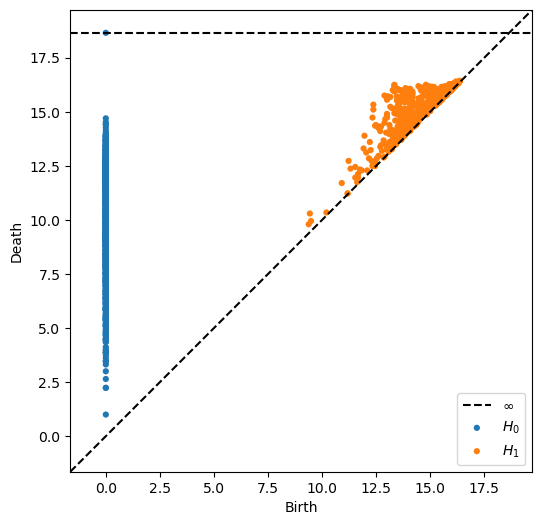

In [13]:
output = pipeline(vertical_lines, 40, 3.8, 1000, 100, 100, 1, 2)
plot_dgms(output)

In [8]:
output = pipeline(vertical_lines, 40, 3.8, 10000, 100, 100, 1, 2)

NameError: name 'pipeline' is not defined

In [ ]:
plot_dgms(output)

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


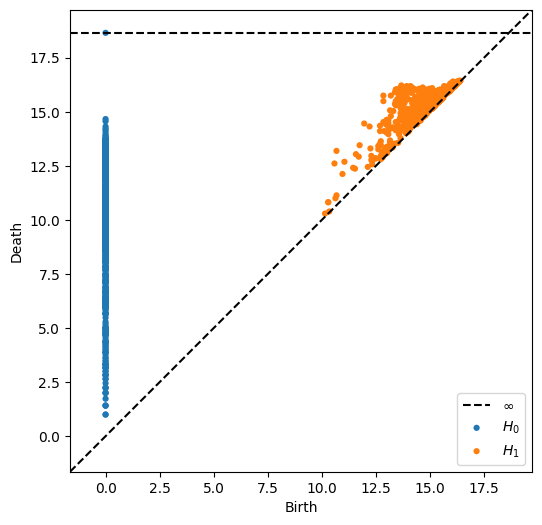

In [15]:
output = pipeline(vertical_lines, 40, 3.8, 1000, 100, 100, 1, 2, 1)
plot_dgms(output)

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


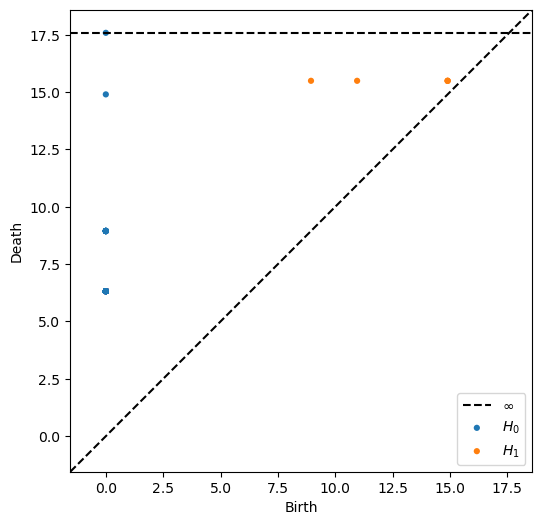

In [20]:
output = pipeline(vertical_lines, num_pixels = 40, window_size = 5, n_isos = 1000, x_translate = 100, y_translate = 100, maxdim = 1, coeff = 2, fixedRadian = 0.5)
plot_dgms(output)